# 神经网络（Neural Network）
https://blog.csdn.net/Yellow_python/article/details/80545909
<br>
https://blog.csdn.net/Yellow_python/article/details/85769987

In [1]:
%matplotlib inline
import matplotlib.pyplot as mp, numpy as np
from sklearn.datasets import make_circles, make_blobs, make_moons

In [2]:
class NN:
    def __init__(self, nn=16, lr=1., precision=1e-7, alpha=0., max_iter=4000):
        self.nn = nn  # 神经元个数
        self.lr = lr  # 学习率
        self.precision = precision  # 允许误差范围
        self.alpha = alpha  # l2正则化惩罚项系数
        self.max_iter = max_iter  # 最大迭代次数
        self.loss = [9e99]  # 记录损失值
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None

    def fit(self, X, y):
        n = X.shape[0]  # 样本数
        d = X.shape[1]  # 维数
        k = len(np.unique(y))  # 种类数
        # 参数初始化
        W1 = 0.01 * np.random.randn(d, self.nn)
        b1 = np.zeros((1, self.nn))
        W2 = 0.01 * np.random.randn(self.nn, k)
        b2 = np.zeros((1, k))
        # 梯度下降循环
        for i in range(self.max_iter):
            # ReLU激活
            hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
            # 得分
            scores = np.dot(hidden_layer, W2) + b2
            # 概率
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            # 记录损失值
            l2 = self.alpha * .5 * (np.sum(np.dot(W1, W1.T)) + np.sum(np.dot(W2, W2.T)))
            loss = np.mean(-np.log(probs[range(n), y])) + l2
            if np.abs(loss - self.loss[-1]) < self.precision:
                break  # 损失值变化足够小时退出迭代
            self.loss.append(loss)
            # 梯度
            probs[range(n), y] -= 1
            dscores = probs / n
            # 反向传播
            dhidden = np.dot(dscores, W2.T)  # 隐层
            dhidden[hidden_layer <= 0] = 0  # ReLU
            # 参数更新：W2、b2
            W2 -= self.lr * np.dot(hidden_layer.T, dscores) + self.alpha * W2
            b2 -= self.lr * np.sum(dscores, axis=0, keepdims=True)
            # 参数更新：W1、b1
            W1 -= self.lr * np.dot(X.T, dhidden) + self.alpha * W1
            b1 -= self.lr * np.sum(dhidden, axis=0, keepdims=True)
        # 训练完成
        self.W1, self.b1 = W1, b1
        self.W2, self.b2 = W2, b2
        self.loss = self.loss[1:]

    def predict(self, X):
        # ReLU激活
        hidden_layer = np.maximum(0, np.dot(X, self.W1) + self.b1)
        # 得分
        scores = np.dot(hidden_layer, self.W2) + self.b2
        # 概率
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return np.round(probs)

    def score(self, X, y):
        y_predict = self.predict(X).reshape(-1)
        return np.mean(y_predict == y)

In [3]:
def visualize(X, y, nn, i, le):
    mp.subplot(1, le, i)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], nn.W1) + nn.b1), nn.W2) + nn.b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    mp.contourf(xx, yy, Z, alpha=.1)
    mp.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=.7)
    mp.axis('off')

#### 探究【神经元个数】对分类结果的影响

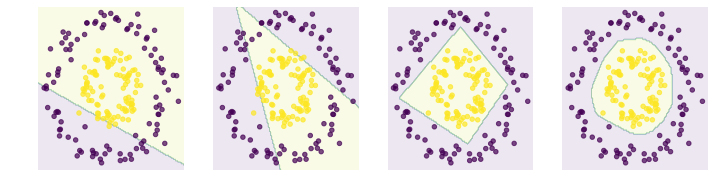

In [4]:
X, y = make_circles(200, noise=.1, factor=.4)  # 创建随机样本
mp.figure(figsize=(12, 3))
ls = [1, 2, 3, 99]  # 神经元个数
le = len(ls)
for i in range(le):
    nn = NN(ls[i])  # 建模
    nn.fit(X, y)  # 拟合
    visualize(X, y, nn, i + 1, le)  # 可视化
mp.show()

#### 探究L2正则化系数

迭代次数：8020 最终损失值：0.0252
迭代次数：10000 最终损失值：0.1276
迭代次数：10000 最终损失值：0.2437
迭代次数：10000 最终损失值：0.7734


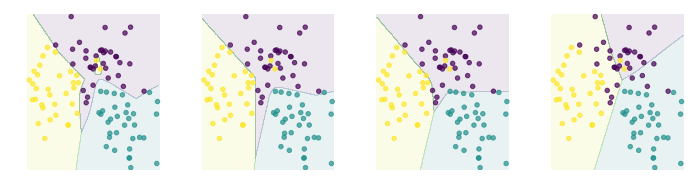

In [5]:
X, y = make_blobs(random_state=0)  # 创建随机样本
mp.figure(figsize=(12, 3))
ls = [0., 1e-3, 1e-2, 1e-1]  # L2正则化系数
le = len(ls)
for i in range(le):
    nn = NN(alpha=ls[i], max_iter=10000)  # 建模
    nn.fit(X, y)  # 拟合
    print('迭代次数：%4d' % len(nn.loss), '最终损失值：%.4f' % nn.loss[-1])
    visualize(X, y, nn, i + 1, le)  # 可视化
mp.show()

#### 探究学习率和损失曲线

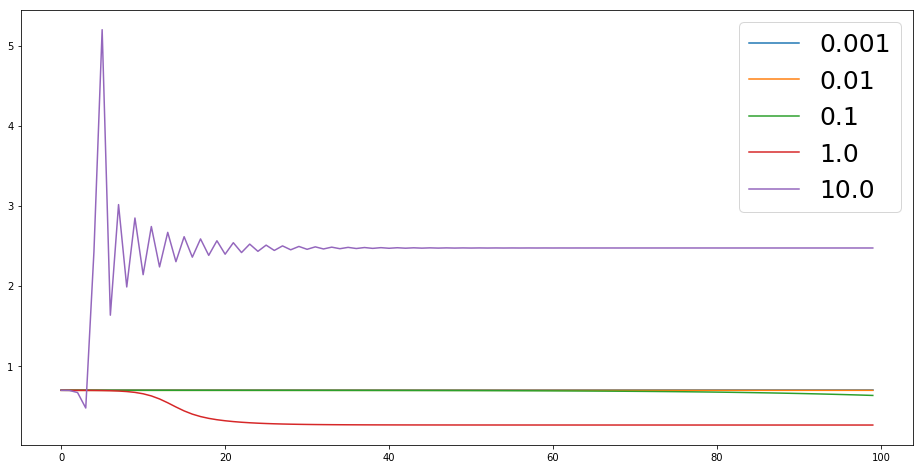

In [17]:
X, y = make_moons()  # 创建随机样本
mp.figure(figsize=(16, 8))
ls = [1e-3, 1e-2, 1e-1, 1., 1e1]  # 学习率
le = len(ls)
for i in range(le):
    nn = NN(lr=ls[i], max_iter=100)  # 建模
    nn.fit(X, y)  # 拟合
    mp.plot(nn.loss, label=str(ls[i]))  # 可视化
mp.legend(prop={'size': 25})
mp.show()